# 🚀 Deep Neural Network Training on Excel Data (PyTorch + Colab + GPU)

In [48]:
!pip install -q openpyxl pandas scikit-learn torch matplotlib

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


In [ ]:
from google.colab import files
uploaded = files.upload()

In [50]:
# Load and prepare data
data = pd.read_excel("merged_sheetsHW2.xlsx")
X = data.iloc[:, [1, 2, 3]].replace('#', -1)
y = data.iloc[:, 4].replace('#', -1)

X = X.apply(pd.to_numeric, errors='coerce').fillna(-1)
y = pd.to_numeric(y, errors='coerce').fillna(-1)

# ✅ Remap labels for classification model
y = y.replace({-1: 0, 0: 1, 1: 2, 2: 3})


<ipython-input-50-4e1107ee8df6>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.iloc[:, 4].replace('#', -1)


In [51]:
import numpy as np
import torch

# Replace '#' with a numeric placeholder  -1 in selected columns
X = data.iloc[:, [1, 2, 3]].replace('#', -1)
y = data.iloc[:, 4].replace('#', -1)

# Convert to numeric safely
X = X.apply(pd.to_numeric, errors='coerce').fillna(-1)
y = pd.to_numeric(y, errors='coerce').fillna(-1)

# Convert to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)


<ipython-input-51-d6818b85e377>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data.iloc[:, 4].replace('#', -1)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [53]:
# After you split into train/test and have tensors: X_tensor, y_tensor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.1, random_state=42
)

# ✅ Now moving tensors to GPU if available
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


In [54]:
import torch.nn as nn
import torch.optim as optim

class DeepNN(nn.Module):
    def __init__(self):
        super(DeepNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
          nn.Linear(32, 4)
        )
    def forward(self, x): return self.net(x)

model = DeepNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
losses = [] #the epoch is set up at 10 and visualitazion every 10
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([16254, 1])) that is different to the input size (torch.Size([16254, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 0.4657
Epoch 20/100, Loss: 0.4449
Epoch 30/100, Loss: 0.4236
Epoch 40/100, Loss: 0.3965
Epoch 50/100, Loss: 0.3727
Epoch 60/100, Loss: 0.3551
Epoch 70/100, Loss: 0.3419
Epoch 80/100, Loss: 0.3333
Epoch 90/100, Loss: 0.3329
Epoch 100/100, Loss: 0.3285


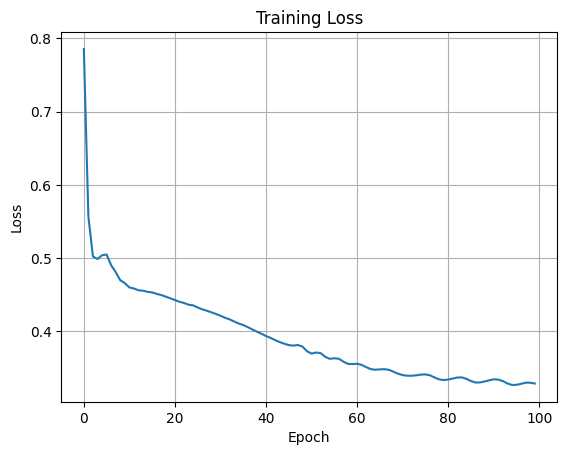

In [56]:
import matplotlib.pyplot as plt #to plot a training loss vs epoch graph
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [57]:
model.eval() #checking the test loss
with torch.no_grad():
    test_preds = model(X_test)
    test_loss = criterion(test_preds, y_test)
print(f"\n🔍 Final Test Loss: {test_loss.item():.4f}")


🔍 Final Test Loss: 0.3157


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1806, 1])) that is different to the input size (torch.Size([1806, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


✅ Test Accuracy: 22.43%


<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


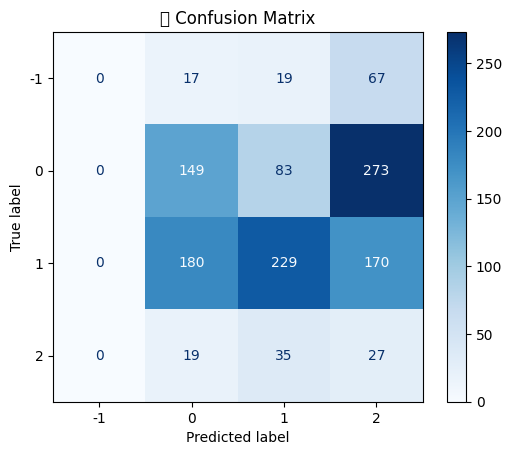

In [58]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ✅ Predict on the test set
with torch.no_grad():
    logits = model(X_test)
    test_preds = torch.argmax(logits, dim=1)

# ✅ Convert predictions and labels to CPU numpy arrays
y_true = y_test.cpu().numpy()
y_pred = test_preds.cpu().numpy()

# ✅ Calculate and display accuracy
acc = accuracy_score(y_true, y_pred)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")

# ✅ Plot confusion matrix
labels = [-1, 0, 1, 2]  # Adjust based on your classes

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("🔍 Confusion Matrix")
plt.grid(False)
plt.show()


In [59]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# During training loop
writer.add_scalar("Loss/train", loss.item(), epoch)
writer.add_scalar("Accuracy/train", acc, epoch)

# After training
writer.close()


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs


In [44]:
# Save only the model weights (recommended for reloading into same architecture)
torch.save(model.state_dict(), "deep_nn_model.pt")

# Save the full model (architecture + weights)
torch.save(model, "deep_nn_model.pth")

print("✅ Model saved as 'deep_nn_model.pt' and 'deep_nn_model.pth'")


✅ Model saved as 'deep_nn_model.pt' and 'deep_nn_model.pth'
